## Repressilator

$$
\frac{d}{dt}X = \frac{1}{\tau}\left(\beta_0\frac{K^n}{K^n + Z^n} - X\right)\\
\frac{d}{dt}Y = \frac{1}{\tau}\left(\beta_0\frac{K^n}{K^n + X^n} - Y\right)\\
\frac{d}{dt}Z = \frac{1}{\tau}\left(\beta_0\frac{K^n}{K^n + Y^n} - Z\right)
$$

In [2]:
function repressilator!(dudt, u, p, t)
    β₀, K, n, τ = p
    X, Y, Z = u
    
    dXdt = 1/τ*(β₀*K^n/(K^n + Z^n) - X)
    dYdt = 1/τ*(β₀*K^n/(K^n + X^n) - Y)
    dZdt = 1/τ*(β₀*K^n/(K^n + Y^n) - Z)
    
    dudt[:] = [dXdt, dYdt, dZdt]
end

repressilator! (generic function with 1 method)

In [3]:
using DifferentialEquations
using Plots; gr();

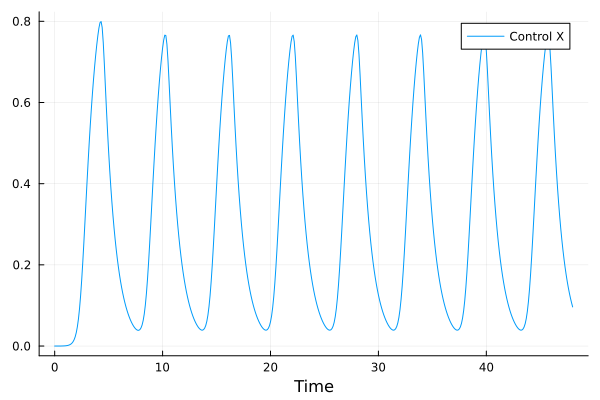

In [4]:
u0 = [0., 0., 1.]
dudt = zeros(Float64, 3)
tspan = (0., 48.)

params = [1., 0.1, 4., 1.]

prob = ODEProblem(repressilator!, u0, tspan, copy(params))
sol = solve(prob, saveat=0.1)

pp = plot(sol.t, hcat(sol.u...)[1, :], xlabel="Time", label="Control X")

In [5]:
include("src/Utils.jl")

attracted_to (generic function with 1 method)

In [8]:
_, _, T₀, _ = attracted_to(repressilator!, u0, 48., params,
                            avg_window=32, conv_tol=1e-4)
T₀

5.9104

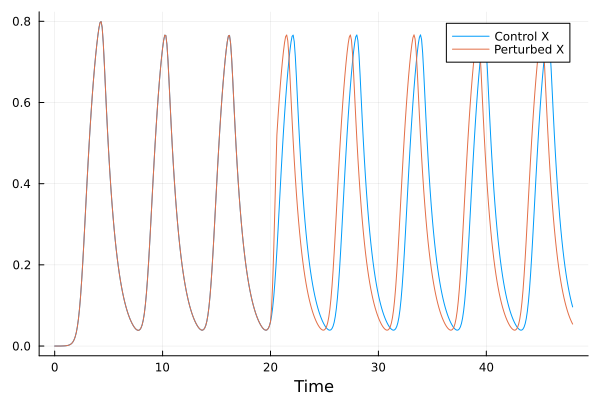

In [10]:
growth_up!(integrator) = integrator.p[4] /= 2
growth_down!(integrator) = integrator.p[4] *= 2

tstart = 20.
cb1 = PresetTimeCallback(tstart, growth_up!)
cb2 = PresetTimeCallback(tstart + 0.1T₀, growth_down!)

sol_p = solve(prob, callback=CallbackSet(cb1, cb2), saveat=0.1)

plot!(pp, sol_p.t, hcat(sol_p.u...)[1, :], label="Perturbed X")

What's the phase shift?

In [11]:
conv_t, _, _, ϕ₀ = attracted_to(repressilator!, u0, 120., params, avg_window=32, conv_tol=1e-5)

tstart = 22.
cb1 = PresetTimeCallback(tstart, growth_up!)
cb2 = PresetTimeCallback(tstart + 0.1T₀, growth_down!)
conv_t, _, _, ϕ = attracted_to(repressilator!, u0, 120., params, callback=CallbackSet(cb1, cb2), burnin=60.,
                                avg_window=32, conv_tol=1e-5)

Δϕ = ϕ - ϕ₀

0.6318209039237666

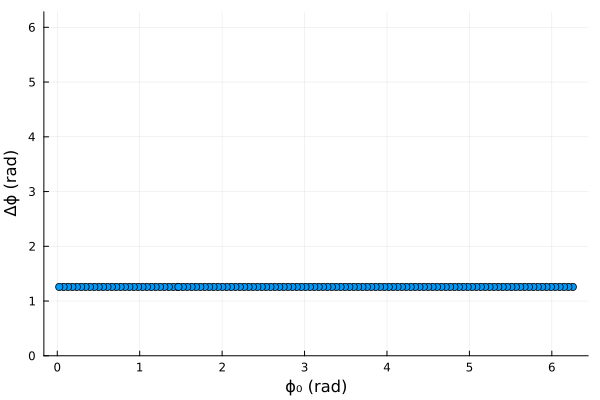

In [13]:
# Perturbation time window ranging from
# 20 to 20 + period

_, _, _, ϕ₀ = attracted_to(repressilator!, u0, 120., params, avg_window=32, conv_tol=1e-5)

t_vec = 40.:0.05:(40 + T₀)
Δϕ_vec = zeros(Float64, length(t_vec))
ϕ₀_vec = @. mod(-t_vec, T₀)/T₀*2π
    
for i in 1:length(t_vec)
    cb1 = PresetTimeCallback(t_vec[i], growth_up!)
    cb2 = PresetTimeCallback(t_vec[i] + 0.2T₀, growth_down!)
    _, _, _, ϕ = attracted_to(repressilator!, u0, 120., params, callback=CallbackSet(cb1, cb2), burnin=80.,
                                    avg_window=32, conv_tol=1e-5)
    Δϕ_vec[i] = ϕ - ϕ₀
end
    
scatter(ϕ₀_vec, Δϕ_vec, xlabel="ϕ₀ (rad)", ylabel="Δϕ (rad)", ylim=(0, 2π), legend=false)

## Goodwin oscillator

$$
\begin{align}
\frac{d}{dt}X &= k_1\frac{K^n}{K^n + Z^n} - k_2X\\
\frac{d}{dt}Y &= k_3X - k_4Y\\
\frac{d}{dt}Z &= k_5Y - k_6Z
\end{align}
$$

Where (without growth)

$$
\begin{align}
k_1 &= 5\\
k_2 &= 1\\
k_3 &= 1\\
k_4 &= 1\\
k_5 &= 5\\
k_6 &= 1\\
K &= 1\\
n &= 16
\end{align}
$$

In [14]:
function goodwin!(dudt, u, p, t)
    k1, k2, k3, k4, k5, k6, K, n = p
    X, Y, Z = u
    
    dXdt = k1*K^n/(K^n + Z^n) - k2*X
    dYdt = k3*X - k4*Y
    dZdt = k5*Y - k6*Z
    
    dudt[:] = [dXdt, dYdt, dZdt]
end

goodwin! (generic function with 1 method)

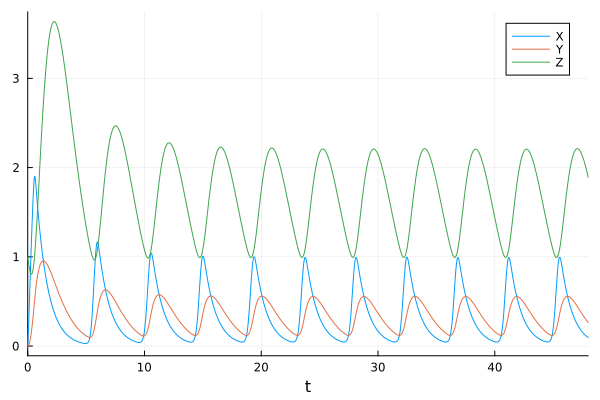

In [15]:
u0 = [0., 0., 1.]
dudt = zeros(Float64, 3)
params = [5., 1., 1., 1., 5., 1., 1., 16.]
tspan = (0., 48.)

prob = ODEProblem(goodwin!, u0, tspan, params)
sol = solve(prob, saveat=0.01)
plot(sol, labels=["X" "Y" "Z"], fmt=:png)

In [21]:
_, _, T₀, _ = attracted_to(goodwin!, u0, 48., params,
                            avg_window=32, conv_tol=1e-4)
print("Intrinsic period = $(T₀)")


Intrinsic period = 4.35984

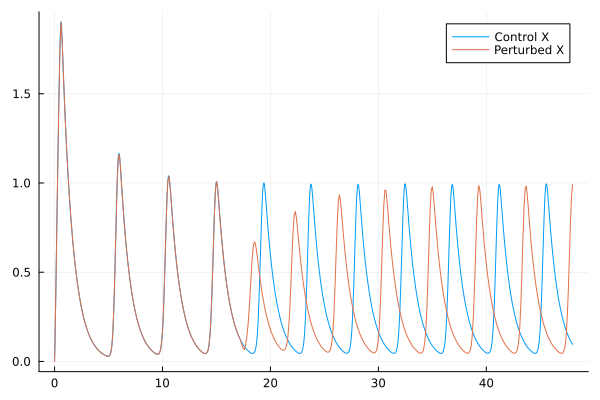

In [22]:
u0 = [0., 0., 1.]
dudt = zeros(Float64, 3)
params = [5., 1., 1., 1., 5., 1., 1., 16.]
tspan = (0., 48.)

prob = ODEProblem(goodwin!, u0, tspan, params)
sol = solve(prob, saveat=0.01)
pp = plot(sol.t, hcat(sol.u...)[1, :], label="Control X")

input_ind = [1, 2, 3, 4, 6]
growth_up!(integrator) = integrator.p[input_ind] .*= 2
growth_down!(integrator) = integrator.p[input_ind] ./= 2

tstart = 20. - T₀*4/(2π)
cb1 = PresetTimeCallback(tstart, growth_up!)
cb2 = PresetTimeCallback(tstart + 0.1T₀, growth_down!)

sol_p = solve(prob, callback=CallbackSet(cb1, cb2), saveat=0.1)

plot!(pp, sol_p.t, hcat(sol_p.u...)[1, :], label="Perturbed X", fmt=:png)

In [23]:
conv_t, _, _, ϕ₀ = attracted_to(goodwin!, u0, 120., params, avg_window=32, conv_tol=1e-4)

tstart = 22.
cb1 = PresetTimeCallback(tstart, growth_up!)
cb2 = PresetTimeCallback(tstart + 0.1T₀, growth_down!)
conv_t, _, _, ϕ = attracted_to(goodwin!, u0, 120., params, callback=CallbackSet(cb1, cb2), burnin=60.,
                                avg_window=32, conv_tol=1e-4)

Δϕ = ϕ - ϕ₀

1.4130482214668123

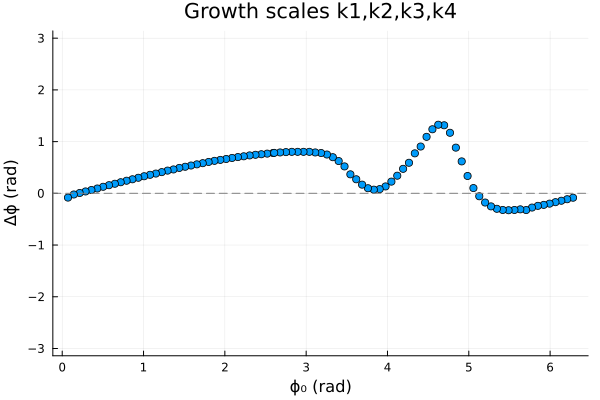

In [39]:
# Perturbation time window ranging from
# 20 to 20 + period

input_ind = 1:4
growth_up!(integrator) = integrator.p[input_ind] .*= 2
growth_down!(integrator) = integrator.p[input_ind] ./= 2

_, _, _, ϕ₀ = attracted_to(goodwin!, u0, 120., params, avg_window=32, conv_tol=1e-4)

t_vec = 20.:0.05:(20 + T₀)
Δϕ_vec = zeros(Float64, length(t_vec))
ϕ₀_vec = @. mod(-t_vec, T₀)/T₀*2π
    
for i in 1:length(t_vec)
    cb1 = PresetTimeCallback(t_vec[i], growth_up!)
    cb2 = PresetTimeCallback(t_vec[i] + 0.1T₀, growth_down!)
    _, _, _, ϕ = attracted_to(goodwin!, u0, 120., params, callback=CallbackSet(cb1, cb2), burnin=60.,
                                    avg_window=32, conv_tol=1e-4)
    Δϕ_vec[i] = ϕ - ϕ₀
end
    
pp = scatter(ϕ₀_vec, Δϕ_vec, xlabel="ϕ₀ (rad)", ylabel="Δϕ (rad)", ylim=(-π, π), legend=false, 
    title="Growth scales "*reduce(*, [",k$(i)" for i in input_ind])[2:end], fmt=:png)

hline!(pp, [0], linestyle=:dash, color=:gray)

display(pp)

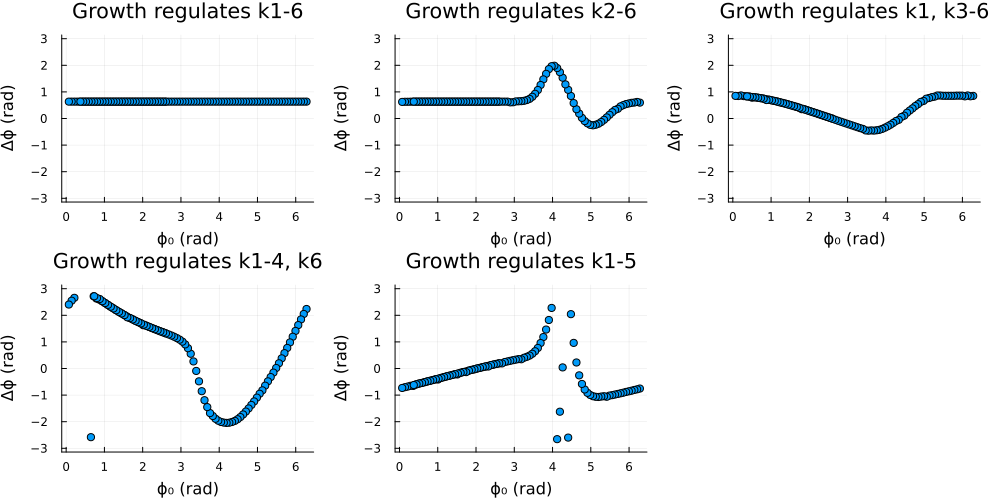

In [228]:
plot(p1, p2, p3, p4, p5, layout=(2, 3), size=(1000, 500), margin=3Plots.mm, fmt=:png)